#Data Load & Create Features

In [2]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# 설정
USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS_MON = 950  # Monitored 데이터 URL 수
TOTAL_URLS_UNMON = 3000  # Unmonitored 데이터 URL 수

# Number of Incoming/Outgoing Packets
def count_in_out_packets(data):
    num_incoming = sum(1 for c in data if c > 0)  # Positive indicates incoming
    num_outgoing = sum(1 for c in data if c < 0)  # Negative indicates outgoing
    return num_incoming, num_outgoing


# Number of Incoming/Outgoing Packets as a Fraction of Total
def fraction_in_out_packets(num_incoming, num_outgoing):
    total_packets = num_incoming + num_outgoing
    if total_packets == 0:  # To avoid division by zero
        return 0, 0
    fraction_incoming = num_incoming / total_packets
    fraction_outgoing = num_outgoing / total_packets
    return fraction_incoming, fraction_outgoing


# Standard Deviation of Outgoing Packet Ordering List
def std_dev_outgoing_packets(data):
    outgoing_sizes = [abs(c) * 512 for c in data if c < 0]  # Only outgoing packets
    if len(outgoing_sizes) > 1:
        return np.std(outgoing_sizes)
    return 0


# Sum of All Items in the Alternative Concentration Feature List
def sum_alternative_concentration(size_seq):
    return sum(size_seq)


# Average of the Outgoing and Total Number of Packets
def avg_outgoing_and_total_packets(num_incoming, num_outgoing):
    total_packets = num_incoming + num_outgoing
    if total_packets == 0:  # To avoid division by zero
        return 0
    avg = (num_outgoing + total_packets) / 2
    return avg


# Sum of Incoming, Outgoing, and Total Number of Packets
def sum_in_out_total_packets(num_incoming, num_outgoing):
    return num_incoming + num_outgoing


# Sum of Alternative Number of Packets per Second
def sum_packets_per_second(time_seq, size_seq):
    total_time = sum(time_seq)
    if total_time == 0:
        return 0
    total_packets = sum(size_seq)
    return total_packets / total_time

# Total Number of Packets
def total_packets(num_incoming, num_outgoing):
    return num_incoming + num_outgoing

# Google 드라이브 마운트
drive.mount('/content/drive')

# 파일 경로 설정 (드라이브에서 파일 경로 확인 필요)
mon_file = '/content/drive/MyDrive/mon_standard.pkl'
unmon_file = '/content/drive/MyDrive/unmon_standard10_3000.pkl'

# 데이터 로드
with open(mon_file, 'rb') as f:
    mon_data = pickle.load(f)
with open(unmon_file, 'rb') as f:
    unmon_data = pickle.load(f)

# Monitored 데이터 변환
X1_mon, X2_mon, X3_mon, X4_mon, X5_mon, X6_mon, X7_mon, X8_mon, X9_mon, y_mon = [], [], [], [], [], [], [], [], [], []

# For monitored data
for i in range(TOTAL_URLS_MON):
    if USE_SUBLABEL:
        label = i
    else:
        label = i // URL_PER_SITE

    for sample in mon_data[i]:
        size_seq = []
        time_seq = []
        cumulative_size = []  # To store the cumulative size
        burst_seq = []  # To store the burst sequence

        prev_size = 0  # To track the previous size for burst calculation
        cumulative_sum = 0  # To calculate cumulative size
        for c in sample:
            dr = 1 if c > 0 else -1
            time_seq.append(abs(c))
            size = dr * 512
            size_seq.append(size)

            # Calculate cumulative size
            cumulative_sum += size
            cumulative_size.append(cumulative_sum)

            # Calculate burst sequence
            if size != prev_size:  # If direction changes, consider it a burst
                burst_seq.append(size)
            else:
                burst_seq.append(0)  # No burst if size is the same as previous

            prev_size = size

        num_incoming, num_outgoing = count_in_out_packets(sample)
        fraction_incoming, fraction_outgoing = fraction_in_out_packets(num_incoming, num_outgoing)
        std_dev_outgoing = std_dev_outgoing_packets(sample)
        sum_alternative = sum_alternative_concentration(size_seq)
        avg_outgoing_total = avg_outgoing_and_total_packets(num_incoming, num_outgoing)
        sum_in_out_total = sum_in_out_total_packets(num_incoming, num_outgoing)
        sum_per_second = sum_packets_per_second(time_seq, size_seq)
        total = total_packets(num_incoming, num_outgoing)

        # Store all features in respective lists
        X1_mon.append(time_seq)
        X2_mon.append(size_seq)
        X3_mon.append(cumulative_size)
        X4_mon.append(burst_seq)
        X5_mon.append(fraction_incoming)
        X6_mon.append(fraction_outgoing)
        X7_mon.append(std_dev_outgoing)
        X8_mon.append(sum_alternative)
        X9_mon.append(avg_outgoing_total)
        y_mon.append(label)

X1_unmon, X2_unmon, X3_unmon, X4_unmon, X5_unmon, X6_unmon, X7_unmon, X8_unmon, X9_unmon = [], [], [], [], [], [], [], [], []

# For unmonitored data
for i in range(TOTAL_URLS_UNMON):
    size_seq = []
    time_seq = []
    cumulative_size = []  # To store the cumulative size
    burst_seq = []  # To store the burst sequence

    prev_size = 0  # To track the previous size for burst calculation
    cumulative_sum = 0  # To calculate cumulative size

    for c in unmon_data[i]:
        dr = 1 if c > 0 else -1
        time_seq.append(abs(c))
        size = dr * 512
        size_seq.append(size)

        # Calculate cumulative size
        cumulative_sum += size
        cumulative_size.append(cumulative_sum)

        # Calculate burst sequence
        if size != prev_size:  # If direction changes, consider it a burst
            burst_seq.append(size)
        else:
            burst_seq.append(0)  # No burst if size is the same as previous

        prev_size = size

    num_incoming, num_outgoing = count_in_out_packets(unmon_data[i])
    fraction_incoming, fraction_outgoing = fraction_in_out_packets(num_incoming, num_outgoing)
    std_dev_outgoing = std_dev_outgoing_packets(unmon_data[i])
    sum_alternative = sum_alternative_concentration(size_seq)
    avg_outgoing_total = avg_outgoing_and_total_packets(num_incoming, num_outgoing)
    sum_in_out_total = sum_in_out_total_packets(num_incoming, num_outgoing)
    sum_per_second = sum_packets_per_second(time_seq, size_seq)
    total = total_packets(num_incoming, num_outgoing)

    # Store all features in respective lists
    X1_unmon.append(time_seq)
    X2_unmon.append(size_seq)
    X3_unmon.append(cumulative_size)
    X4_unmon.append(burst_seq)
    X5_unmon.append(fraction_incoming)
    X6_unmon.append(fraction_outgoing)
    X7_unmon.append(std_dev_outgoing)
    X8_unmon.append(sum_alternative)
    X9_unmon.append(avg_outgoing_total)

# Monitored와 Unmonitored 데이터를 Pandas 데이터프레임으로 변환
mon_df = pd.DataFrame({
    'Fraction Incoming (X5)': X5_mon,
    'Fraction Outgoing (X6)': X6_mon,
    'Std Dev Outgoing (X7)': X7_mon,
    'Sum Alternative (X8)': X8_mon,
    'Average Outgoing & Total (X9)': X9_mon,
    'Label': ['Monitored'] * len(X5_mon)
})

unmon_df = pd.DataFrame({
    'Fraction Incoming (X5)': X5_unmon,
    'Fraction Outgoing (X6)': X6_unmon,
    'Std Dev Outgoing (X7)': X7_unmon,
    'Sum Alternative (X8)': X8_unmon,
    'Average Outgoing & Total (X9)': X9_unmon,
    'Label': ['Unmonitored'] * len(X5_unmon)
})

# 데이터 병합
data = pd.concat([mon_df, unmon_df], ignore_index=True)
print("데이터 로드 및 준비 완료!")

Mounted at /content/drive
데이터 로드 및 준비 완료!


#Random Forest Model_Openworld _ Select X6, X7, X8, X9 feature


Model Performance:
Accuracy: 0.48
Classification Report:
              precision    recall  f1-score   support

          -1       0.32      0.36      0.34       882
           0       0.36      0.34      0.35        58
           1       0.32      0.22      0.26        60
           2       0.76      0.76      0.76        62
           3       0.36      0.35      0.35        46
           4       0.41      0.66      0.51        50
           5       0.58      0.53      0.56        60
           6       0.76      0.67      0.71        63
           7       0.36      0.42      0.39        50
           8       0.55      0.54      0.54        54
           9       0.35      0.40      0.37        48
          10       0.53      0.48      0.50        67
          11       0.64      0.50      0.56        64
          12       0.81      0.84      0.82        61
          13       0.44      0.25      0.32        76
          14       0.38      0.32      0.34        57
          15       0.55

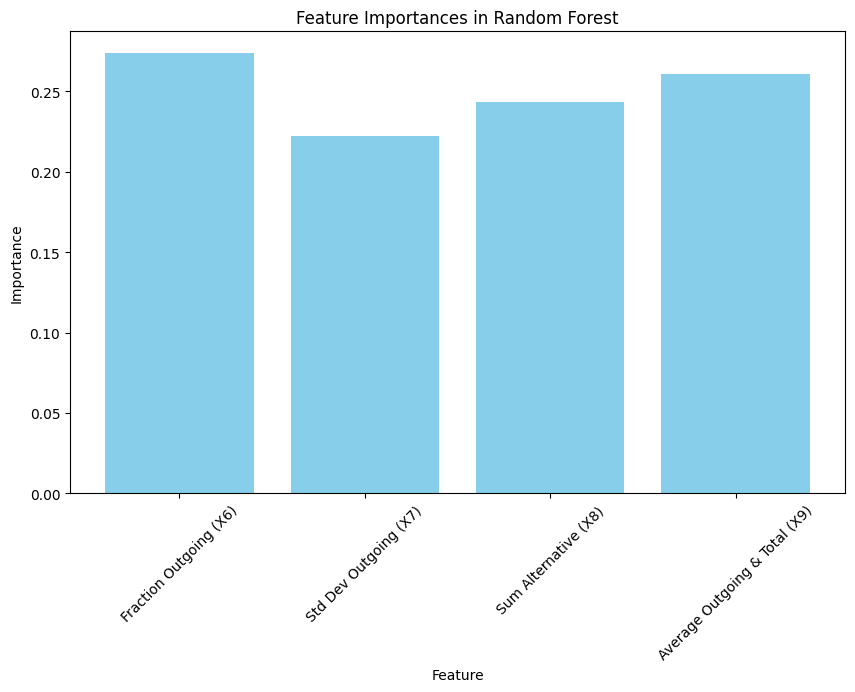

In [11]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Step 1: Monitored 데이터 준비 (0 ~ 94 레이블)
mon_features = pd.DataFrame({
    'Fraction Outgoing (X6)': X6_mon,
    'Std Dev Outgoing (X7)': X7_mon,
    'Sum Alternative (X8)': X8_mon,
    'Average Outgoing & Total (X9)': X9_mon,
    'Label': y_mon  # 0 ~ 94 레이블이 이미 존재한다고 가정
})

# Step 2: Unmonitored 데이터 준비 (-1 레이블)
unmon_features = pd.DataFrame({
    'Fraction Outgoing (X6)': X6_unmon,
    'Std Dev Outgoing (X7)': X7_unmon,
    'Sum Alternative (X8)': X8_unmon,
    'Average Outgoing & Total (X9)': X9_unmon,
    'Label': [-1] * len(X6_unmon)  # 모든 Unmonitored 데이터에 -1 레이블 할당
})

# Monitored와 Unmonitored 데이터 병합
data = pd.concat([mon_features, unmon_features], ignore_index=True)

# Step 3: 특징과 레이블 분리
X = data.drop('Label', axis=1)  # 특징 데이터 (X6, X7, X8, X9만 사용)
y = data['Label']  # 레이블 데이터 (0 ~ 94 및 -1)

# Step 4: 데이터 분할 (학습 데이터와 테스트 데이터)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 5: 랜덤포레스트 모델 생성 및 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # 100개의 트리
rf_model.fit(X_train, y_train)

# Step 6: 테스트 데이터로 예측
y_pred = rf_model.predict(X_test)

# 정확도 및 성능 평가
accuracy = accuracy_score(y_test, y_pred)

print("\nModel Performance:")
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Step 7: 특징 중요도 계산 및 시각화
feature_importances = rf_model.feature_importances_

# 그래프 시각화
plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importances, color='skyblue')
plt.title("Feature Importances in Random Forest")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.show()


#Random Forest - Closed World _ Select X6, X7, X8, X9 feature


Model Performance:
Accuracy: 0.54
Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.32      0.34        62
           1       0.35      0.25      0.29        59
           2       0.60      0.82      0.69        55
           3       0.36      0.52      0.43        46
           4       0.55      0.60      0.58        53
           5       0.63      0.63      0.63        63
           6       0.67      0.75      0.71        65
           7       0.60      0.48      0.53        64
           8       0.55      0.58      0.56        59
           9       0.36      0.62      0.45        47
          10       0.69      0.53      0.60        66
          11       0.58      0.53      0.55        57
          12       0.81      0.88      0.85        59
          13       0.29      0.24      0.26        54
          14       0.47      0.34      0.40        58
          15       0.58      0.69      0.63        59
          16       0.62

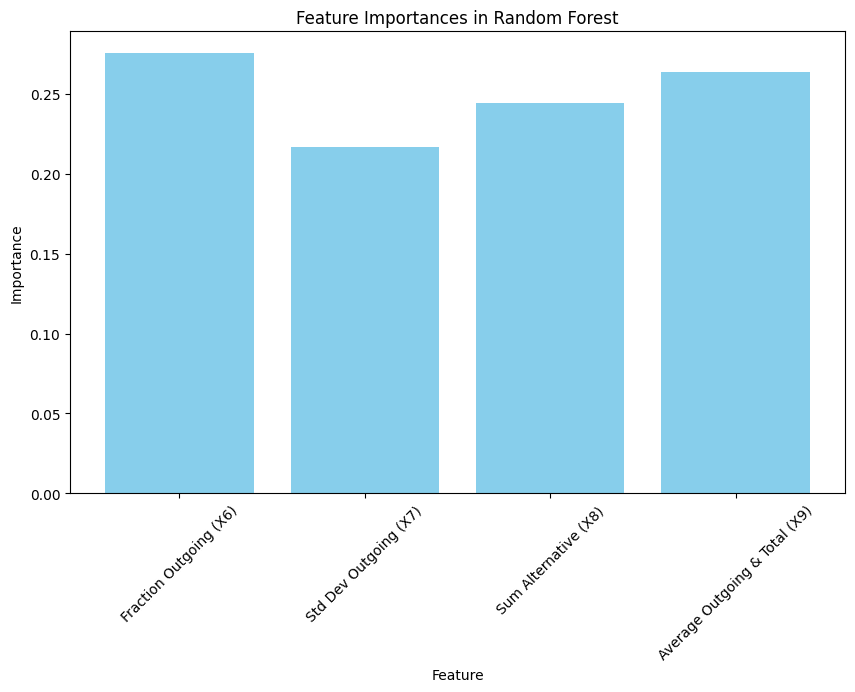

In [10]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Step 1: 특징 데이터 준비
# X6 ~ X9 특징 데이터프레임 생성 (특정 특징만 사용)
mon_features = pd.DataFrame({
    'Fraction Outgoing (X6)': X6_mon,
    'Std Dev Outgoing (X7)': X7_mon,
    'Sum Alternative (X8)': X8_mon,
    'Average Outgoing & Total (X9)': X9_mon,
})

# y_mon을 그대로 레이블로 사용
mon_features['Label'] = y_mon  # y_mon에는 이미 19000개의 레이블이 존재

# Step 2: 특징과 레이블 분리
X = mon_features.drop('Label', axis=1)  # 특정 특징만 포함
y = mon_features['Label']  # 레이블 데이터

# Step 3: 데이터 분할 (학습 데이터와 테스트 데이터)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: 랜덤포레스트 모델 생성 및 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # 100개의 트리
rf_model.fit(X_train, y_train)

# Step 5: 테스트 데이터로 예측
y_pred = rf_model.predict(X_test)

# 정확도 및 성능 평가
accuracy = accuracy_score(y_test, y_pred)

print("\nModel Performance:")
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Step 6: 특징 중요도 계산 및 시각화
feature_importances = rf_model.feature_importances_

# 그래프 시각화
plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importances, color='skyblue')
plt.title("Feature Importances in Random Forest")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.show()


#SVM_OPENWORLD

데이터 병합 완료!
모델 정확도: 73.70%


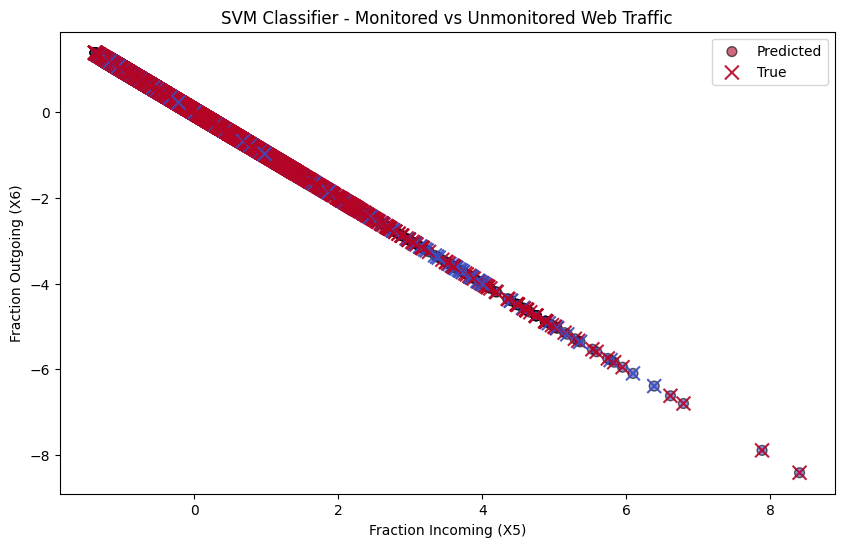

In [15]:
# Features(X1 ~ X9)와 Labels 준비
# 데이터 병합 수정
mon_df = pd.DataFrame({
    'Fraction Incoming (X5)': X5_mon,
    'Fraction Outgoing (X6)': X6_mon,
    'Std Dev Outgoing (X7)': X7_mon,
    'Sum Alternative (X8)': X8_mon,
    'Average Outgoing & Total (X9)': X9_mon,
    'Label': ['Monitored'] * len(X5_mon)
})

unmon_df = pd.DataFrame({
    'Fraction Incoming (X5)': X5_unmon,
    'Fraction Outgoing (X6)': X6_unmon,
    'Std Dev Outgoing (X7)': X7_unmon,
    'Sum Alternative (X8)': X8_unmon,
    'Average Outgoing & Total (X9)': X9_unmon,
    'Label': ['Unmonitored'] * len(X5_unmon)
})

# 데이터 병합
data = pd.concat([mon_df, unmon_df], ignore_index=True)
print("데이터 병합 완료!")

X = data[['Fraction Incoming (X5)', 'Fraction Outgoing (X6)', 'Std Dev Outgoing (X7)',
          'Sum Alternative (X8)', 'Average Outgoing & Total (X9)']].values
y = data['Label'].apply(lambda x: 1 if x == 'Monitored' else -1).values  # Monitored: 1, Unmonitored: -1

# 데이터 분할: 학습용과 테스트용
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature Scaling (SVM 모델에선 중요한 단계)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVM 모델 학습
svm_model = SVC(kernel='linear', random_state=42, probability=True, class_weight='balanced')
svm_model.fit(X_train_scaled, y_train)

# 예측
y_pred = svm_model.predict(X_test_scaled)

# 정확도 계산
accuracy = accuracy_score(y_test, y_pred)
print(f"모델 정확도: {accuracy * 100:.2f}%")

# 그래프 시각화
plt.figure(figsize=(10, 6))

# SVM 분류 경계 시각화: 두 특성을 사용한 2D 그래프
plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=y_pred, cmap='coolwarm', edgecolors='k', s=50, alpha=0.6)
plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=y_test, cmap='coolwarm', marker='x', s=100, alpha=0.9)

plt.title("SVM Classifier - Monitored vs Unmonitored Web Traffic")
plt.xlabel('Fraction Incoming (X5)')
plt.ylabel('Fraction Outgoing (X6)')
plt.legend(["Predicted", "True"], loc="best")
plt.show()



Confusion Matrix:
[[ 280  602]
 [1134 4584]]

Classification Report:
              precision    recall  f1-score   support

          -1       0.20      0.32      0.24       882
           1       0.88      0.80      0.84      5718

    accuracy                           0.74      6600
   macro avg       0.54      0.56      0.54      6600
weighted avg       0.79      0.74      0.76      6600



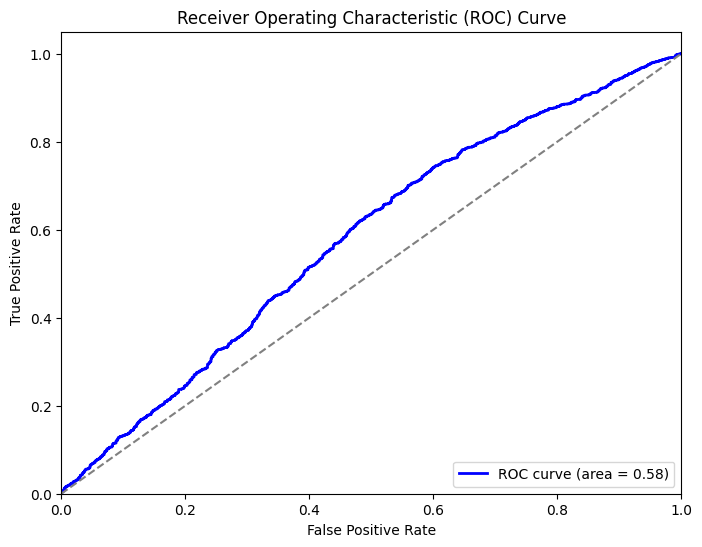

In [16]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# 혼동 행렬
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# 분류 성능 리포트 (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, svm_model.decision_function(X_test_scaled))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
